In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import datetime as dt

sys.path.append('../')
from functions.dain import Adaptive_Normalizer_Layer
from functions.adaptive_normalization import process
from functions.fit_one_cycle import OneCycleScheduler
from functions.lr_finder import LRFinder

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
import tensorflow_probability as tfp


from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# .filter(regex=r'^(?!news_.*$)|(?=.*news__High|news__Medium)')

df_1T = pd.read_parquet('df_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True).dropna()
df_5T = pd.read_parquet('df_5T.parquet').dropna()
df_15T = pd.read_parquet('df_15T.parquet').dropna()
df_1H = pd.read_parquet('df_1H.parquet').dropna()
df_4H = pd.read_parquet('df_4H.parquet').dropna()
df_1B = pd.read_parquet('df_1B.parquet').dropna()

In [5]:
# Define the data generator function
def normalize_and_yield(batch_data, batch_targets):
    # Convert to np.array
    batch_data = np.asarray(batch_data)
    batch_targets = np.asarray(batch_targets)
    
    # Normalize
    cols_to_standardize = [c for c in df_1B.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]
    cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]

    for i in range(batch_data.shape[0]):
        #for j in range(batch_data.shape[1]):
        a = batch_data[i, :, :, cols_to_standardize]
        scaler = MinMaxScaler()
        #batch_data[i, :, :, cols_to_standardize] = scaler.fit_transform(a)
        batch_data[i, :, :, cols_to_standardize] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])

    batch_data = batch_data.astype('float32')
    batch_data = np.split(batch_data, 6, axis=1)
    batch_data = [element.squeeze(axis=1) for element in batch_data]

    return np.asarray(batch_data).astype('float32'), batch_targets.astype('float32')


def data_generator(data, window_size, batch_size, indices):
    batch_data = []
    batch_targets = []
    i=0
    for index in indices:
        dt_index = df_1T.iloc[index].name
        
        input_sequences = np.array([
            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-window_size:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-window_size:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-window_size:].fillna(0).values.astype('float32'),
            df_1H.loc[:dt_index-pd.Timedelta(hours=1)][-window_size:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-window_size:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-window_size:].fillna(0).values.astype('float32')
        ])

        # Extract the target high and low values
        dt_index_noon = dt_index.replace(hour=12, minute=0, second=0)
        dt_index_market_close = dt_index.replace(hour=16, minute=0, second=0)
        
        high_time = df_1T[dt_index : dt_index_market_close].high_es.idxmax().replace(tzinfo=None)
        low_time = df_1T[dt_index : dt_index_market_close].low_es.idxmin().replace(tzinfo=None)
        
        #high_time = int((high_time  - high_time.replace(hour=9, minute=30)).total_seconds() // 60)
        #low_time = int((low_time  - low_time.replace(hour=9, minute=30)).total_seconds() // 60)
        
        targets = [
        
        #high_time,
        #low_time,
        df_1T[dt_index : dt_index_noon].high_es.max(), #morning
        df_1T[dt_index : dt_index_noon].low_es.min(),
        df_1T[dt_index : dt_index_noon].high_nq.max(),
        df_1T[dt_index : dt_index_noon].low_nq.min(),
        df_1T[dt_index : dt_index_market_close].high_es.max(), #daily
        df_1T[dt_index : dt_index_market_close].low_es.min(),
        df_1T[dt_index : dt_index_market_close].high_nq.max(),
        df_1T[dt_index : dt_index_market_close].low_nq.min(),
        high_time > low_time
            
        ]


        # Add the input sequence and targets to the batch
        batch_data.append(input_sequences)
        batch_targets.append(targets)
        print(i, len(indices)) if i % 256 == 0 else None
        i += 1
        
    return normalize_and_yield(batch_data, batch_targets)


                
# Set the window size and batch size
window_size = 90 # minutes
batch_size = 64
num_features = df_1B.shape[1]

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
data_indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > df_1T[df_1B[:window_size+1].iloc[-1].name:].iloc[0]['index'].astype(int))]['index'].to_numpy()
X, y = data_generator(df_1T, window_size, batch_size, data_indices)

separate_nq = 0
if separate_nq:
    X_nq = X
    X_nq[:, :, :, [0,1,2,3,7,8,9,10]] = X_nq[:, :, :, [7,8,9,10,0,1,2,3]]
    X = np.concatenate([X, X_nq], axis=1)

    y_nq = y[:,2:]
    y = np.concatenate([y[:,:2], y_nq])

0 3597
256 3597
512 3597
768 3597
1024 3597
1280 3597
1536 3597
1792 3597
2048 3597
2304 3597
2560 3597
2816 3597
3072 3597
3328 3597
3584 3597


#### We need to normalize each sample, normalizing the entire batch adds data leakage from the future
#### current most appropriate method is to normalize each timeframe within each sample individually
#### we can fracdiff up until end of 2021, then use that fitted scaler for the remaining test data
#### try this and see what we get.

## Shuffle Indices

In [6]:
# read the y-values from the saved csv file
#y = pd.read_csv('targets.csv').values


# Get the total number of samples and calculate the split index
num_samples = X.shape[1]
train_ratio = 0.9
split_index = int(num_samples * train_ratio)

# Shuffle the indices
np.random.seed(42)
shuffle = 1
indices = np.random.permutation(np.arange(num_samples)) if shuffle else np.arange(num_samples)

# Split the array based on the shuffled indices
X_train = list(X[:, indices[:split_index], :, :])
y_train = y[indices[:split_index]]
X_test = list(X[:, indices[split_index:], :, :])
y_test = y[indices[split_index:]]

## Normalize

In [7]:
# Reshape X_train to a np array
X_train = np.asarray(X_train)

# only get columns we want to standardize
cols_to_standardize = [c for c in df_1B.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]
cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]
a = X_train[:,:,:,cols_to_standardize]

# Fit the scaler to the data and transform X_train
scaler = StandardScaler()
X_train[:,:,:,cols_to_standardize] = scaler.fit_transform(a.reshape((-1, a.shape[-1]))).reshape(a.shape)

X_train = list(X_train)

with open('StandardScaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [8]:
X_train = np.split(np.array(X_train), 6, axis=1)
X_train = [element.squeeze(axis=1) for element in X_train]

ValueError: array split does not result in an equal division

In [9]:
# Define the Transformer model

# Define the input layer
main_inputs = [

    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size)

]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    #x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
#output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mae', metrics=['mse'], run_eagerly=False)

2023-11-07 21:55:51.889553: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-07 21:55:51.889579: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-07 21:55:51.889592: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-07 21:55:51.889807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-07 21:55:51.890108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
conda install -c conda-forge pydot


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /Users/kush/Documents/DS/env/DS

  added / updated specs:
    - pydot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.16.0               |       h302bd0f_5         1.0 MB
    expat-2.5.0                |       hb7217d7_1         115 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed37_0         684 KB  conda-forge
    font-ttf-ubuntu-0.83       |       ha

In [10]:
#model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
epochs = 300
lr = 1e-2

train_steps_per_epoch = len(X_train[0]) // batch_size

#lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)
lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)
lr_finder = LRFinder()

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights based on the monitored metric
)

# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model_test.h5',  # Filepath to save the best model
    monitor='val_loss',  # Metric to monitor for saving the best model
    save_best_only=True  # Save only the best model based on the monitored metric
)

history = model.fit(X_train, y_train[:,1], epochs=epochs, validation_split=0.11111, verbose=1, batch_size=64,
                    callbacks=[lr_schedule, early_stopping, tensorboard_callback])

# Plot the training and validation loss and MAE
plt.semilogy(history.history['loss'], label='mae')
plt.semilogy(history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 0
plt.legend()
plt.show()

model.save('best_model_test.keras')

## Model Testing

In [38]:
# Reshape X_train to a np array
X_test = np.asarray(X_test)

# only get columns we want to standardize
cols_to_standardize = [c for c in df_1B.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]
cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]
a = X_test[:,:,:,cols_to_standardize]

# Fit the scaler to the data and transform X_train
X_test[:,:,:,cols_to_standardize] = scaler.transform(a.reshape((-1, a.shape[-1]))).reshape(a.shape)

NameError: name 'scaler' is not defined

In [45]:
X_test = np.split(X_test, 6, axis=1)
X_test = [element.squeeze(axis=1) for element in X_test]

In [140]:
# Generate predictions for the test set
morning_high_model = tf.keras.models.load_model('best_model_high.keras', compile=False)
morning_high_model.optimizer = tf.keras.optimizers.legacy.Adam()
morning_high_model.compile()

morning_low_model = tf.keras.models.load_model('best_model_low.keras', compile=False)
morning_low_model.optimizer = tf.keras.optimizers.legacy.Adam()
morning_low_model.compile()

morning_high_predictions = morning_high_model.predict(list(X_test))
morning_low_predictions = morning_low_model.predict(list(X_test))

# Create a dictionary with the arrays
data = {
    'date': pd.to_datetime(df_1T.iloc[data_indices].index.date[indices][split_index:]),
    'p_morning_high': morning_high_predictions.reshape(len(morning_high_predictions)),
    'morning_high': y_test[:,0].reshape(len(y_test[:,0])),
    'p_morning_low': morning_low_predictions.reshape(len(morning_low_predictions)),
    'morning_low': y_test[:,1].reshape(len(y_test[:,1])),
    'daily_high': y_test[:,4].reshape(len(y_test[:,4])),
    'daily_low': y_test[:,5].reshape(len(y_test[:,5])),
}

# Convert the dictionary to a DataFrame
res = pd.DataFrame(data).set_index('date').astype(float).round(2)
res['dh'] = res.morning_high - res.p_morning_high
res['dl'] = res.p_morning_low - res.morning_low

dates = [(d.strftime('%Y-%m-%d 09:30:00'), d.strftime('%Y-%m-%d 12:00:00')) for d in res.index.date]
high_first = []
for d in dates:
    high_first.append(df_1T.loc[d[0]: d[1]].high_es.idxmax() < df_1T.loc[d[0]: d[1]].low_es.idxmin())
res['high_first'] = high_first
    
#res = res[res.index.year >= 2022]

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")

57/57 [==============================] - 1s 11ms/step


In [141]:
sl = np.arange(1, int(res[['dl', 'dh']].abs().mean().mean()))
rr = np.arange(1, int(res[['dl', 'dh']].abs().mean().mean()))

results = []
total_taken = res[((res.dh > 0) & (res.high_first)) | ((res.dl > 0) & (~res.high_first))].shape[0] #only count the trades taken (where the p comes before the actual, i.e. ignore where the actual doesnt hit the p)

for i in sl:
    for j in rr:        
        longs_won = res[(res.dl < i) & (res.dl >= 0) & (res.daily_high >= res.p_morning_low + j * i) & res.high_first].shape[0]
        shorts_won = res[(res.dh < i) & (res.dh >= 0) & (res.daily_low <= res.p_morning_high - j * i) & (~res.high_first)].shape[0]
        total_return = (longs_won + shorts_won) * j - (total_taken - longs_won - shorts_won)
        prob_win = (longs_won + shorts_won) / total_taken
        result = {'sl': i, 
                  'rr': j, 
                  'total_taken': total_taken, 
                  'longs_won': longs_won, 
                  'shorts_won': shorts_won, 
                  'total_return': total_return,
                  'prob_win': prob_win
                 }
        results.append(result)
        
t = pd.DataFrame(results)
#t = t[(t.total_return > 0) & (t.prob_win > .5)]


In [145]:
res

,p_morning_high,morning_high,p_morning_low,morning_low,daily_high,daily_low,dh,dl,high_first
date,,,,,,,,,
2016-09-19,48.55,45.92,44.67,43.05,46.46,43.05,-2.63,1.62,False
2020-06-02,83.95,62.69,62.37,54.40,62.69,52.20,-21.26,7.97,True
2022-09-26,83.14,94.66,80.23,74.87,94.66,74.87,11.52,5.36,True
2014-01-02,33.24,36.66,29.85,32.86,36.90,32.86,3.42,-3.01,True
2019-04-04,58.46,58.53,54.22,55.50,59.14,54.71,0.07,-1.28,True
...,...,...,...,...,...,...,...,...,...
2013-10-08,31.60,33.66,30.02,31.49,34.04,31.49,2.06,-1.47,True
2014-06-02,34.58,38.38,27.52,34.98,38.38,34.98,3.80,-7.46,True
2012-09-14,29.95,28.26,25.61,26.06,28.26,25.87,-1.69,-0.45,False


In [144]:
t.sort_values(['total_return', 'prob_win'], ascending=[False, False])

,sl,rr,total_taken,longs_won,shorts_won,total_return,prob_win
3,2,1,882,156,110,-350,0.301587
1,1,2,882,99,64,-393,0.184807
2,1,3,882,66,47,-430,0.128118
6,3,1,882,128,97,-432,0.255102
0,1,1,882,108,74,-518,0.206349
4,2,2,882,71,42,-543,0.128118
7,3,2,882,41,23,-690,0.072562
5,2,3,882,32,16,-690,0.054422
8,3,3,882,20,12,-754,0.036281


In [33]:
import mplfinance as mpf

In [48]:
temp = df_5T.loc['2022-07-25 03:00':'2022-07-26 09:30'].rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32')#df.resample('1B').agg(keep_cols['1B']).dropna().convert_dtypes()


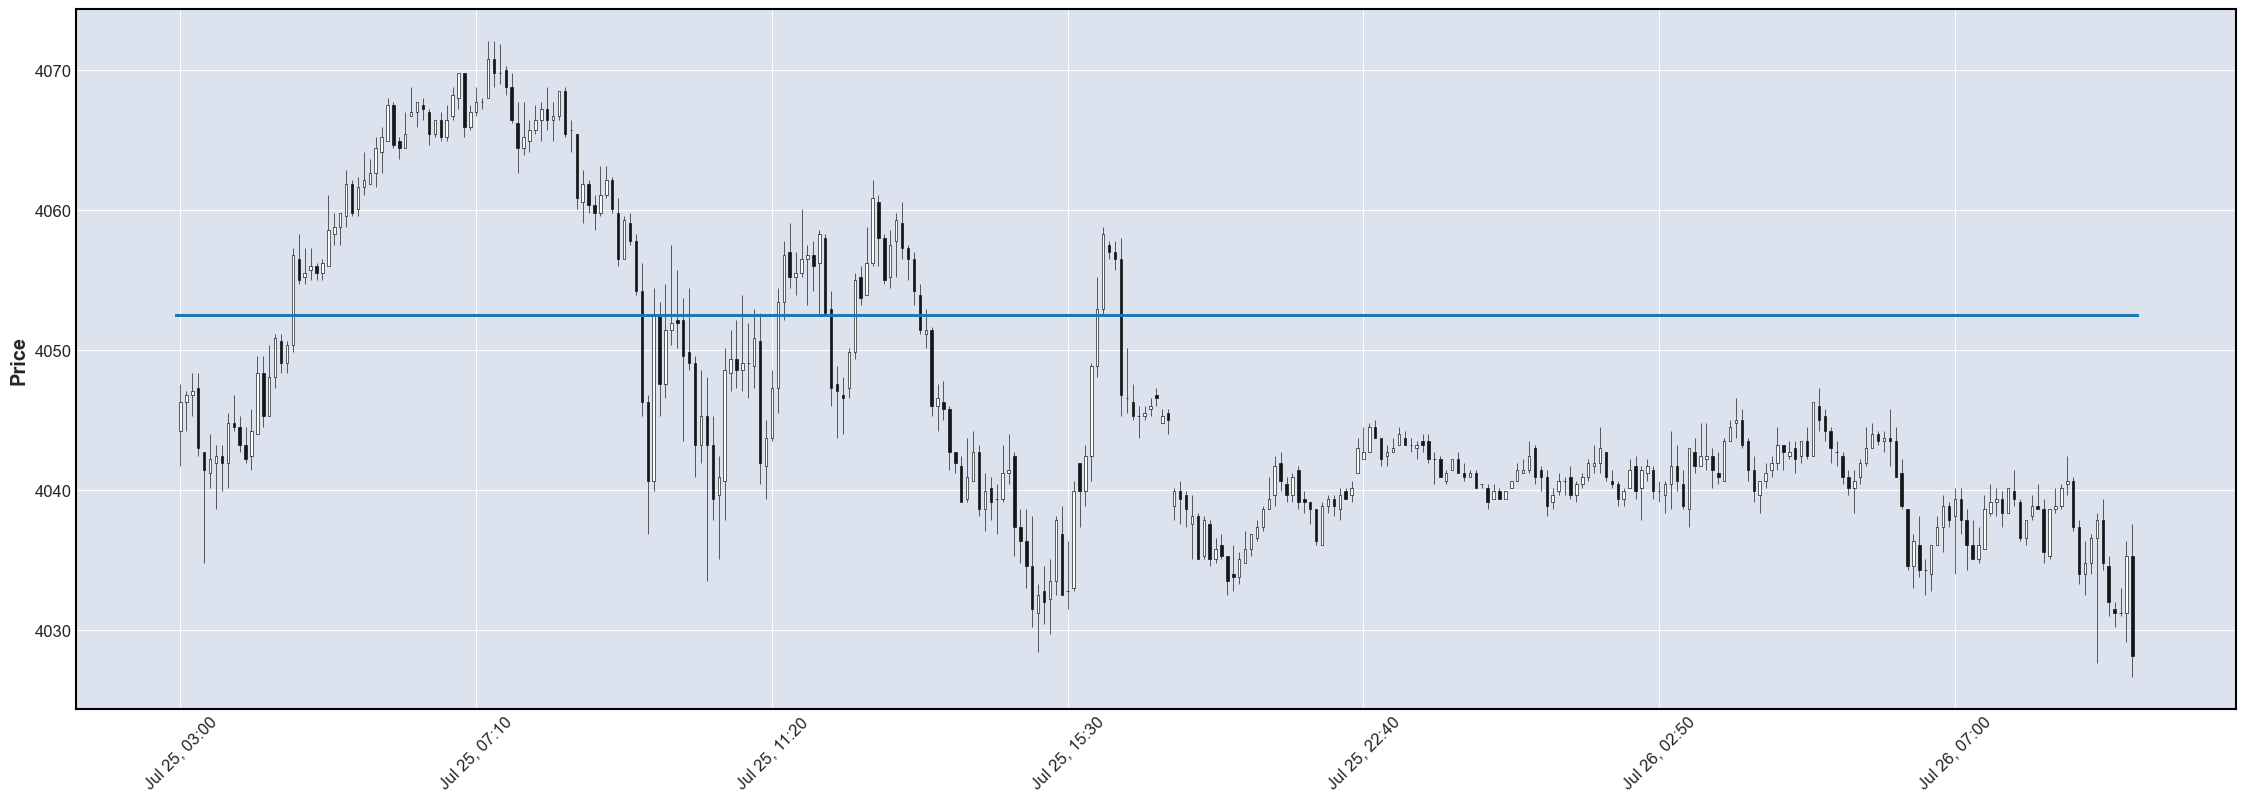

In [49]:
mpf.plot(temp, type='candle', figsize=(30,10), hlines=[4052.54])

In [9]:
import pandas as pd
from pandas import Timestamp
from pytvlwcharts import *

In [17]:
temp = df_1T.rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32')
temp.index.name = 'time'
temp.index = temp.index.tz_localize(None)
temp.reset_index(inplace=True)
temp['datetime'] = temp.time
temp.set_index('datetime', inplace=True)
temp.time = pd.to_datetime(temp.time).apply(lambda x : x.timestamp())
temp = temp[['time', 'open', 'high', 'low', 'close']]

In [ ]:
from matplotlib.widgets import MultiCursor
date = '2009-12-04'
start = f'{date} 09:30'
end = f'{date} 16:00'
fig, axlist = mpf.plot(temp.loc[start : end], type='candle', figsize=(15,5), returnfig=True, ylim=(980,1010))
multi = MultiCursor(fig.canvas, axlist, color='lime',lw=1.2, horizOn=True, vertOn=True)

In [21]:
date = '2009-12-08'
start = f'{date} 09:30'
end = f'{date} 16:00'

FifteenMinuteChart = Chart(
    data=temp.loc[start : end],
    width = 1360,
    height = 500,
    time_scale=TimeScaleOptions(
        seconds_visible=True,
        time_visible=True)
    ).mark_candlestick()
FifteenMinuteChart

DatetimeIndex(['2008-12-11 03:44:00-05:00', '2008-12-11 03:45:00-05:00',
               '2008-12-11 03:46:00-05:00', '2008-12-11 03:49:00-05:00',
               '2008-12-11 03:50:00-05:00', '2008-12-11 03:51:00-05:00',
               '2008-12-11 03:54:00-05:00', '2008-12-11 03:55:00-05:00',
               '2008-12-11 03:56:00-05:00', '2008-12-11 04:01:00-05:00',
               ...
               '2023-05-17 00:37:00-04:00', '2023-05-17 00:42:00-04:00',
               '2023-05-17 00:43:00-04:00', '2023-05-17 00:46:00-04:00',
               '2023-05-17 00:49:00-04:00', '2023-05-17 00:50:00-04:00',
               '2023-05-17 00:53:00-04:00', '2023-05-17 00:54:00-04:00',
               '2023-05-17 00:55:00-04:00', '2023-05-17 01:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='datetime', length=3520675, freq=None)